In [9]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from scipy.stats import gmean
# from scipy import stats

In [10]:
pd.set_option('display.max_columns', None)


Belgium



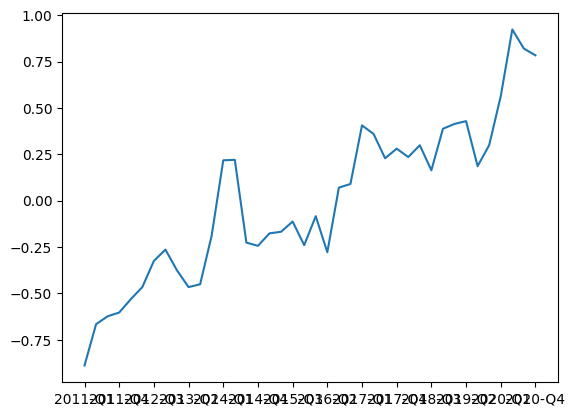


Czechia



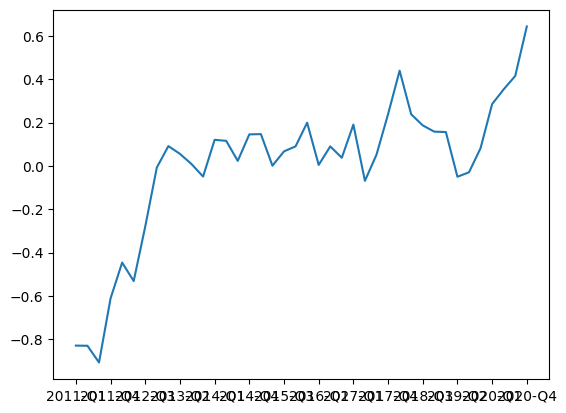


Denmark



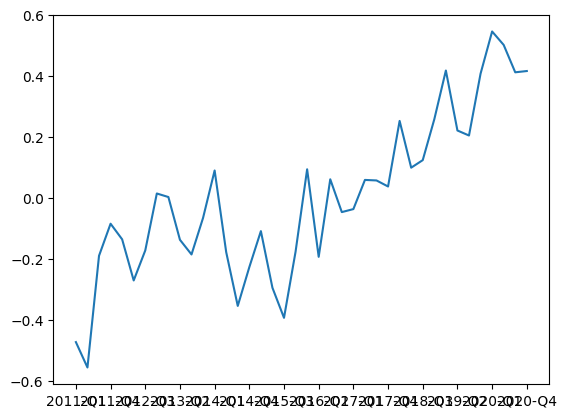


Spain



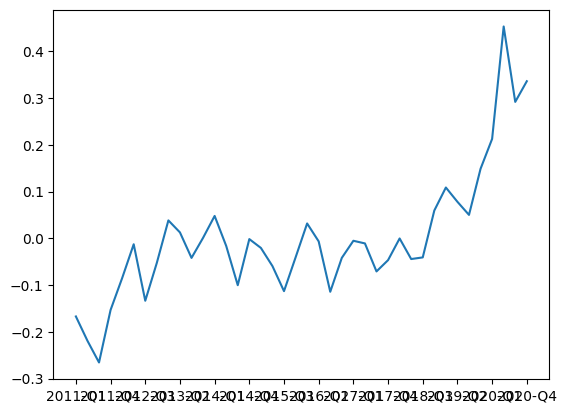


Italy



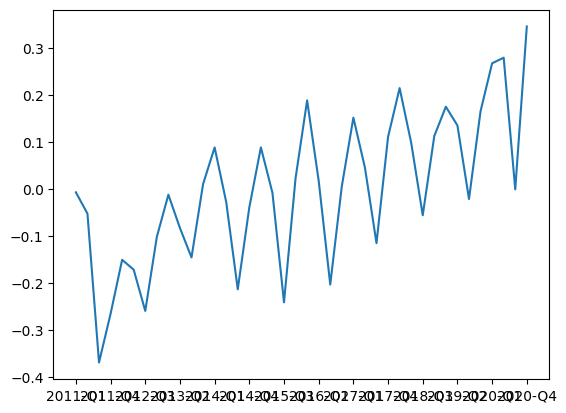


Lithuania



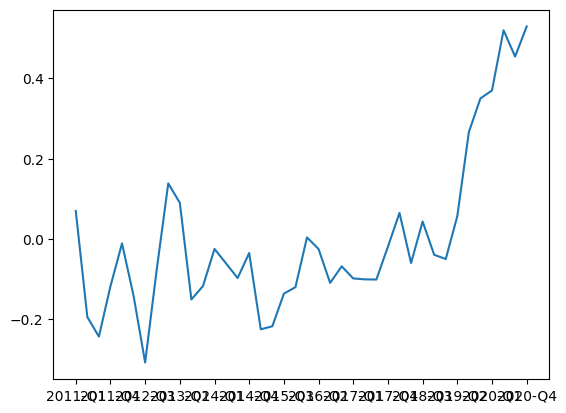


Poland



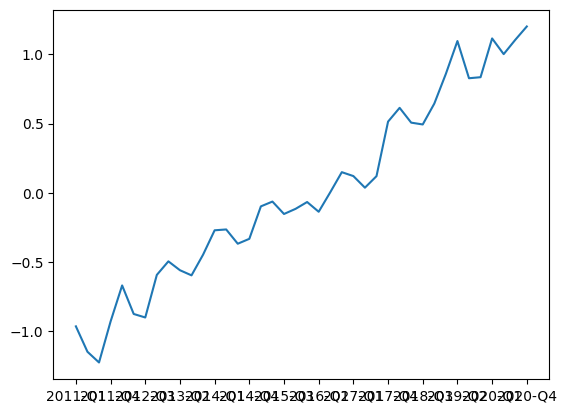


Finland



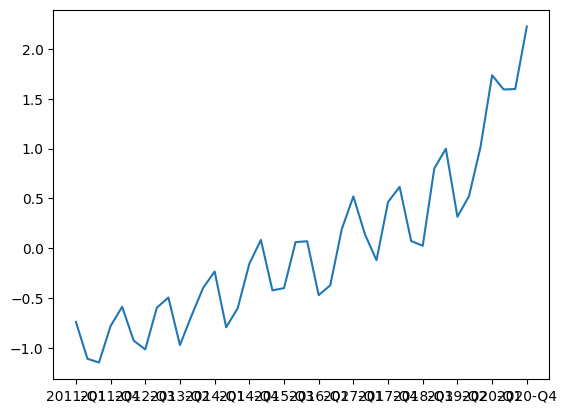


Sweden



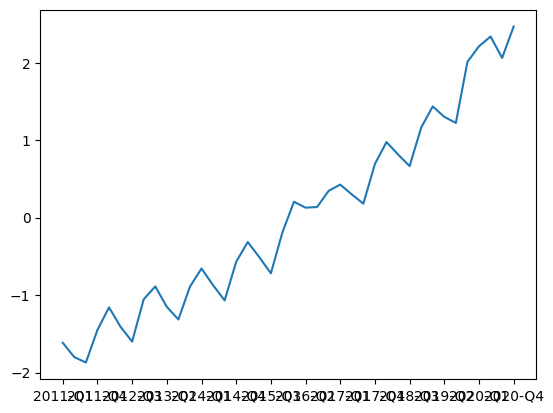

In [11]:
onet_tasks_path = "Data/onet_tasks.csv"
eurostat_employment_isco = "Data/Eurostat_employment_isco.xlsx"

# Import data from the O*NET database, at ISCO-08 occupation level.
# The original data uses a version of SOC classification, but the data we load here
# are already cross-walked to ISCO-08 using: https://ibs.org.pl/en/resources/occupation-classifications-crosswalks-from-onet-soc-to-isco/

# The O*NET database contains information for occupations in the USA, including
# the tasks and activities typically associated with a specific occupation.
task_data = pd.read_csv(onet_tasks_path)
# isco08 variable is for occupation codes
# the t_* variables are specific tasks conducted on the job

# read employment data from Eurostat
# These datasets include quarterly information on the number of workers in specific
# 1-digit ISCO occupation categories. (Check here for details: https://www.ilo.org/public/english/bureau/stat/isco/isco08/)
isco_df = {}
for i in range(1,10):
    isco_df[f"isco{i}"] = pd.read_excel(eurostat_employment_isco, sheet_name=f"ISCO{i}")
    
# We will focus on three countries, but perhaps we could clean this code to allow it
# to easily run for all the countries in the sample?
country_names = isco_df["isco1"].columns[2:]
country_agg = {}
for country in country_names:
    for _, data in isco_df.items():
        country_agg.setdefault(f"total_{country}", 0)
        country_agg[f"total_{country}"] = data[country]

# Let's merge all these datasets. We'll need a column that stores the occupation categories:
for i in range(1,10):
    isco_df[f"isco{i}"]["ISCO"] = i
    
# and this gives us one large file with employment in all occupations.
all_data = pd.concat(isco_df.values(), ignore_index=True)

# We have 9 occupations and the same time range for each, so we can add the totals by
# adding a vector that is 9 times the previously calculated totals
for country in country_names:
    all_data[f"total_{country}"] = pd.concat([country_agg[f"total_{country}"]]*9, ignore_index=True)

    # And this will give us shares of each occupation among all workers in a period-country    
    all_data[f"share_{country}"] = all_data[country] / all_data[f"total_{country}"]

# Now let's look at the task data. We want the first digit of the ISCO variable only

task_data["isco08_1dig"] = task_data["isco08"].astype(str).str[:1].astype(int)

# And we'll calculate the mean task values at a 1-digit level 
# (more on what these tasks are below)
aggdata = task_data.groupby(["isco08_1dig"]).mean()
aggdata = aggdata.drop(columns=["isco08"])

# We'll be interested in tracking the intensity of Non-routine cognitive analytical tasks
# Using a framework reminiscent of the work by David Autor.

#These are the ones we're interested in:
# Non-routine cognitive analytical
# 4.A.2.a.4 Analyzing Data or Information
# 4.A.2.b.2 Thinking Creatively
# 4.A.4.a.1 Interpreting the Meaning of Information for Others

#Let's combine the data.
combined = pd.merge(all_data, aggdata, left_on='ISCO', right_on='isco08_1dig', how='left')
# Traditionally, the first step is to standardise the task values using weights 
# defined by share of occupations in the labour force. This should be done separately
# for each country. Standardisation -> getting the mean to 0 and std. dev. to 1.
# Let's do this for each of the variables that interests us:    

task_items = ["t_4A2a4", "t_4A2b2", "t_4A4a1"]
agg_country = {}
for task_item in task_items:
    for country in country_names:
        temp_mean = np.average(combined[task_item], weights=combined[f"share_{country}"])
        temp_sd = np.sqrt(np.average((combined[task_item] - temp_mean)**2, weights=combined[f"share_{country}"]))
        combined[f"std_{country}_{task_item}"] = (combined[task_item] - temp_mean) / temp_sd
        
# The next step is to calculate the `classic` task content intensity, i.e.
# how important is a particular general task content category in the workforce
# Here, we're looking at non-routine cognitive analytical tasks, as defined
# by David Autor and Darron Acemoglu:
for country in country_names:
    combined[f"{country}_NRCA"] = combined[f"std_{country}_{task_items[0]}"] + combined[f"std_{country}_{task_items[1]}"] + combined[f"std_{country}_{task_items[2]}"]

    # And we standardise NRCA in a similar way.
    temp_mean = np.average(combined[f"{country}_NRCA"], weights=combined[f"share_{country}"])
    temp_sd = np.sqrt(np.average((combined[f"{country}_NRCA"] - temp_mean)**2, weights=combined[f"share_{country}"]))
    combined[f"std_{country}_NRCA"] = (combined[f"{country}_NRCA"] - temp_mean) / temp_sd
    
    # Finally, to track the changes over time, we have to calculate a country-level mean
    # Step 1: multiply the value by the share of such workers.
    combined[f"multip_{country}_NRCA"] = combined[f"std_{country}_NRCA"] * combined[f"share_{country}"]
    
    # Step 2: sum it up (it basically becomes another weighted mean)
    agg_country[f"agg_{country}"] = combined.groupby(["TIME"])[f"multip_{country}_NRCA"].sum().reset_index()
    
    # We can plot it now!
    print("\n" + country + "\n")
    plt.plot(agg_country[f"agg_{country}"]["TIME"], agg_country[f"agg_{country}"][f"multip_{country}_NRCA"])
    plt.xticks(range(0, len(agg_country[f"agg_{country}"]), 3), agg_country[f"agg_{country}"]["TIME"][::3])
    plt.show()

# 1

In [49]:
onet_tasks_path = "Data/onet_tasks.csv"
eurostat_employment_isco = "Data/Eurostat_employment_isco.xlsx"

# Import data from the O*NET database, at ISCO-08 occupation level.
# The original data uses a version of SOC classification, but the data we load here
# are already cross-walked to ISCO-08 using: https://ibs.org.pl/en/resources/occupation-classifications-crosswalks-from-onet-soc-to-isco/

# The O*NET database contains information for occupations in the USA, including
# the tasks and activities typically associated with a specific occupation.
task_data = pd.read_csv(onet_tasks_path)
# isco08 variable is for occupation codes
# the t_* variables are specific tasks conducted on the job

# read employment data from Eurostat
# These datasets include quarterly information on the number of workers in specific
# 1-digit ISCO occupation categories. (Check here for details: https://www.ilo.org/public/english/bureau/stat/isco/isco08/)

isco_df = {}
for i in range(1,10):
    isco_df[f"isco{i}"] = pd.read_excel(eurostat_employment_isco, sheet_name=f"ISCO{i}")
    
# We will focus on three countries, but perhaps we could clean this code to allow it
# to easily run for all the countries in the sample?

country_names = isco_df["isco1"].columns[2:]
country_agg = {}
for country in country_names:
    for _, data in isco_df.items():
        country_agg.setdefault(f"total_{country}", 0)
        country_agg[f"total_{country}"] = data[country]
    


In [25]:
# Sets the path to the parent directory of RR classes
# os.chdir("Z:\\File folders\\Teaching\\Reproducible Research\\2023\\Repository\\RRcourse2023\\6. Coding and documentation")

# Import data from the O*NET database, at ISCO-08 occupation level.
# The original data uses a version of SOC classification, but the data we load here
# are already cross-walked to ISCO-08 using: https://ibs.org.pl/en/resources/occupation-classifications-crosswalks-from-onet-soc-to-isco/

# The O*NET database contains information for occupations in the USA, including
# the tasks and activities typically associated with a specific occupation.

task_data = pd.read_csv(onet_tasks_path)
# isco08 variable is for occupation codes
# the t_* variables are specific tasks conducted on the job

# read employment data from Eurostat
# These datasets include quarterly information on the number of workers in specific
# 1-digit ISCO occupation categories. (Check here for details: https://www.ilo.org/public/english/bureau/stat/isco/isco08/)


    


isco1 = pd.read_excel(eurostat_employment_isco, sheet_name="ISCO1")
isco2 = pd.read_excel("Data\\Eurostat_employment_isco.xlsx", sheet_name="ISCO2")
isco3 = pd.read_excel("Data\\Eurostat_employment_isco.xlsx", sheet_name="ISCO3")
isco4 = pd.read_excel("Data\\Eurostat_employment_isco.xlsx", sheet_name="ISCO4")
isco5 = pd.read_excel("Data\\Eurostat_employment_isco.xlsx", sheet_name="ISCO5")
isco6 = pd.read_excel("Data\\Eurostat_employment_isco.xlsx", sheet_name="ISCO6")
isco7 = pd.read_excel("Data\\Eurostat_employment_isco.xlsx", sheet_name="ISCO7")
isco8 = pd.read_excel("Data\\Eurostat_employment_isco.xlsx", sheet_name="ISCO8")
isco9 = pd.read_excel("Data\\Eurostat_employment_isco.xlsx", sheet_name="ISCO9")

# We will focus on three countries, but perhaps we could clean this code to allow it
# to easily run for all the countries in the sample?

# This will calculate worker totals in each of the chosen countries.
total_Belgium = isco1["Belgium"] + isco2["Belgium"] + isco3["Belgium"] + isco4["Belgium"] + isco5["Belgium"] + isco6["Belgium"] + isco7["Belgium"] + isco8["Belgium"] + isco9["Belgium"]
total_Spain = isco1["Spain"] + isco2["Spain"] + isco3["Spain"] + isco4["Spain"] + isco5["Spain"] + isco6["Spain"] + isco7["Spain"] + isco8["Spain"] + isco9["Spain"]
total_Poland = isco1["Poland"] + isco2["Poland"] + isco3["Poland"] + isco4["Poland"] + isco5["Poland"] + isco6["Poland"] + isco7["Poland"] + isco8["Poland"] + isco9["Poland"]

# 2

In [54]:
# Let's merge all these datasets. We'll need a column that stores the occupation categories:
for i in range(1,10):
    isco_df[f"isco{i}"]["ISCO"] = i
    
# and this gives us one large file with employment in all occupations.
all_data = pd.concat(isco_df.values(), ignore_index=True)

# We have 9 occupations and the same time range for each, so we can add the totals by
# adding a vector that is 9 times the previously calculated totals
for country in country_names:
    all_data[f"total_{country}"] = pd.concat([country_agg[f"total_{country}"]]*9, ignore_index=True)

    # And this will give us shares of each occupation among all workers in a period-country    
    all_data[f"share_{country}"] = all_data[country] / all_data[f"total_{country}"]
    


In [26]:
# Let's merge all these datasets. We'll need a column that stores the occupation categories:
isco1['ISCO'] = 1
isco2['ISCO'] = 2
isco3['ISCO'] = 3
isco4['ISCO'] = 4
isco5['ISCO'] = 5
isco6['ISCO'] = 6
isco7['ISCO'] = 7
isco8['ISCO'] = 8
isco9['ISCO'] = 9

# and this gives us one large file with employment in all occupations.
all_data = pd.concat([isco1, isco2, isco3, isco4, isco5, isco6, isco7, isco8, isco9], ignore_index=True)

# We have 9 occupations and the same time range for each, so we can add the totals by
# adding a vector that is 9 times the previously calculated totals
all_data["total_Belgium"] = pd.concat([total_Belgium]*9, ignore_index=True)
all_data["total_Spain"] = pd.concat([total_Spain]*9, ignore_index=True)
all_data["total_Poland"] = pd.concat([total_Poland]*9, ignore_index=True)

# And this will give us shares of each occupation among all workers in a period-country
all_data['share_Belgium'] = all_data['Belgium'] / all_data['total_Belgium']
all_data['share_Spain'] = all_data['Spain'] / all_data['total_Spain']
all_data['share_Poland'] = all_data['Poland'] / all_data['total_Poland']

In [57]:
task_data.head()

,isco08,t_1A1f1,t_1A2a2,t_2B1a,t_4A2a4,t_4A2b2,t_4A3a3,t_4A3a4,t_4A4a1,t_4A4a4,t_4A4b4,t_4A4b5,t_4C2d1g,t_4C2d1i,t_4C3b4,t_4C3b7,t_4C3d3,t_4C3b8_rev,t_4C1a2l_rev,t_4A4a5_rev,t_4A4a8_rev,t_4A1b2_rev,t_4A3a2_rev,t_4A3b4_rev,t_4A3b5_rev
0,1112,1.561667,1.373333,3.916667,3.898333,3.806667,1.970000,2.206667,3.931667,4.376667,4.258333,3.903333,2.175000,2.330000,3.846667,3.028333,1.370000,1.443333,1.193333,3.215000,2.353333,3.186667,4.023333,4.365000,4.381667
1,1113,1.185000,1.000000,4.000000,4.105000,4.180000,1.380000,1.420000,4.075000,4.390000,4.225000,3.780000,1.815000,2.270000,3.790000,2.735000,1.390000,1.330000,1.130000,3.795000,2.950000,3.630000,4.520000,4.835000,4.805000
2,1114,1.416667,1.510000,3.750000,3.848333,3.457500,2.370833,2.370000,3.677500,4.052500,3.820000,3.635000,2.319167,2.413333,4.079167,3.331667,1.488333,1.422500,1.225833,3.276667,2.597500,2.725833,3.767500,3.953333,4.114167
3,1120,1.342500,1.250000,4.000000,3.907500,3.750000,2.035000,1.910000,3.797500,4.165000,4.187500,3.855000,2.117500,2.355000,3.890000,3.162500,1.495000,1.265000,1.090000,3.427500,2.550000,3.100000,4.015000,4.297500,4.432500
4,1211,1.000000,1.166667,3.290000,4.400000,3.603333,1.400000,1.130000,3.533333,4.026667,3.560000,3.673333,2.193333,2.500000,4.513333,3.356667,1.180000,1.640000,1.110000,3.770000,3.570000,4.243333,4.686667,4.990000,4.883333


# 2 - 3

In [58]:
# Now let's look at the task data. We want the first digit of the ISCO variable only

task_data["isco08_1dig"] = task_data["isco08"].astype(str).str[:1].astype(int)

# And we'll calculate the mean task values at a 1-digit level 
# (more on what these tasks are below)
aggdata = task_data.groupby(["isco08_1dig"]).mean()
aggdata = aggdata.drop(columns=["isco08"])

# We'll be interested in tracking the intensity of Non-routine cognitive analytical tasks
# Using a framework reminiscent of the work by David Autor.

#These are the ones we're interested in:
# Non-routine cognitive analytical
# 4.A.2.a.4 Analyzing Data or Information
# 4.A.2.b.2 Thinking Creatively
# 4.A.4.a.1 Interpreting the Meaning of Information for Others

#Let's combine the data.
combined = pd.merge(all_data, aggdata, left_on='ISCO', right_on='isco08_1dig', how='left')
# Traditionally, the first step is to standardise the task values using weights 
# defined by share of occupations in the labour force. This should be done separately
# for each country. Standardisation -> getting the mean to 0 and std. dev. to 1.
# Let's do this for each of the variables that interests us:



# 3

In [63]:
task_items = ["t_4A2a4", "t_4A2b2", "t_4A4a1"]

for task_item in task_items:
    for country in country_names:
        temp_mean = np.average(combined[task_item], weights=combined[f"share_{country}"])
        temp_sd = np.sqrt(np.average((combined[task_item] - temp_mean)**2, weights=combined[f"share_{country}"]))
        combined[f"std_{country}_{task_item}"] = (combined[task_item] - temp_mean) / temp_sd

In [33]:

#first task item

temp_mean=np.average(combined["t_4A2a4"],weights=combined["share_Belgium"])
temp_sd=np.sqrt(np.average((combined["t_4A2a4"]-temp_mean)**2,weights=combined["share_Belgium"]))
combined["std_Belgium_t_4A2a4"]=(combined["t_4A2a4"]-temp_mean)/temp_sd

temp_mean=np.average(combined["t_4A2a4"],weights=combined["share_Poland"])
temp_sd=np.sqrt(np.average((combined["t_4A2a4"]-temp_mean)**2,weights=combined["share_Poland"]))
combined["std_Poland_t_4A2a4"]=(combined["t_4A2a4"]-temp_mean)/temp_sd

temp_mean=np.average(combined["t_4A2a4"],weights=combined["share_Spain"])
temp_sd=np.sqrt(np.average((combined["t_4A2a4"]-temp_mean)**2,weights=combined["share_Spain"]))
combined["std_Spain_t_4A2a4"]=(combined["t_4A2a4"]-temp_mean)/temp_sd
#second task item

temp_mean=np.average(combined["t_4A2b2"],weights=combined["share_Belgium"])
temp_sd=np.sqrt(np.average((combined["t_4A2b2"]-temp_mean)**2,weights=combined["share_Belgium"]))
combined["std_Belgium_t_4A2b2"]=(combined["t_4A2b2"]-temp_mean)/temp_sd

temp_mean=np.average(combined["t_4A2b2"],weights=combined["share_Poland"])
temp_sd=np.sqrt(np.average((combined["t_4A2b2"]-temp_mean)**2,weights=combined["share_Poland"]))
combined["std_Poland_t_4A2b2"]=(combined["t_4A2b2"]-temp_mean)/temp_sd

temp_mean=np.average(combined["t_4A2b2"],weights=combined["share_Spain"])
temp_sd=np.sqrt(np.average((combined["t_4A2b2"]-temp_mean)**2,weights=combined["share_Spain"]))
combined["std_Spain_t_4A2b2"]=(combined["t_4A2b2"]-temp_mean)/temp_sd

#third task item

temp_mean=np.average(combined["t_4A4a1"],weights=combined["share_Belgium"])
temp_sd=np.sqrt(np.average((combined["t_4A4a1"]-temp_mean)**2,weights=combined["share_Belgium"]))
combined["std_Belgium_t_4A4a1"]=(combined["t_4A4a1"]-temp_mean)/temp_sd

temp_mean=np.average(combined["t_4A4a1"],weights=combined["share_Poland"])
temp_sd=np.sqrt(np.average((combined["t_4A4a1"]-temp_mean)**2,weights=combined["share_Poland"]))
combined["std_Poland_t_4A4a1"]=(combined["t_4A4a1"]-temp_mean)/temp_sd

temp_mean=np.average(combined["t_4A4a1"],weights=combined["share_Spain"])
temp_sd=np.sqrt(np.average((combined["t_4A4a1"]-temp_mean)**2,weights=combined["share_Spain"]))
combined["std_Spain_t_4A4a1"]=(combined["t_4A4a1"]-temp_mean)/temp_sd

# 4


Belgium



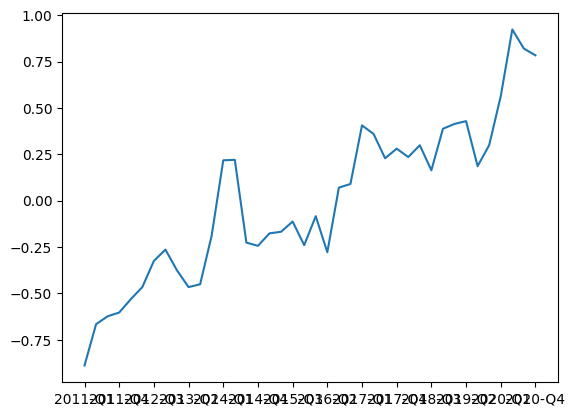


Czechia



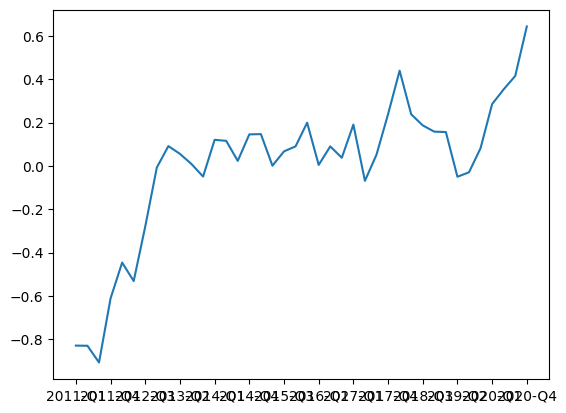


Denmark



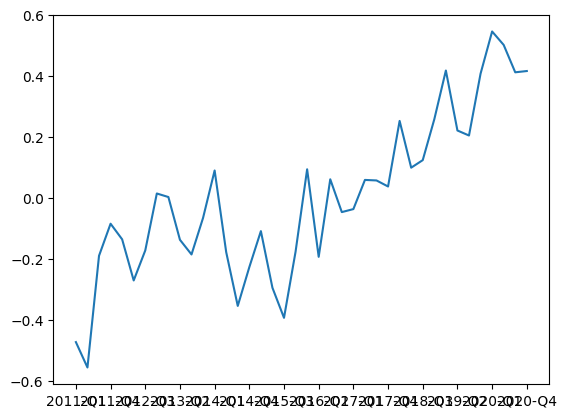


Spain



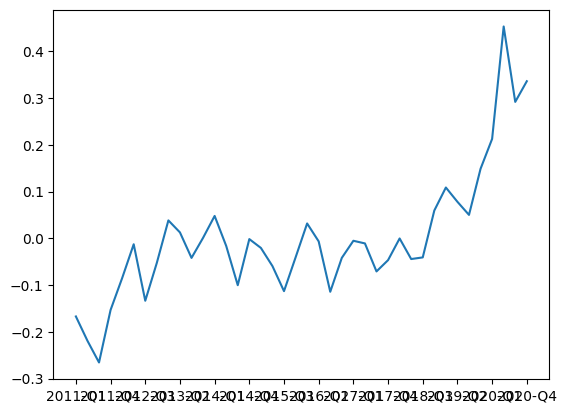


Italy



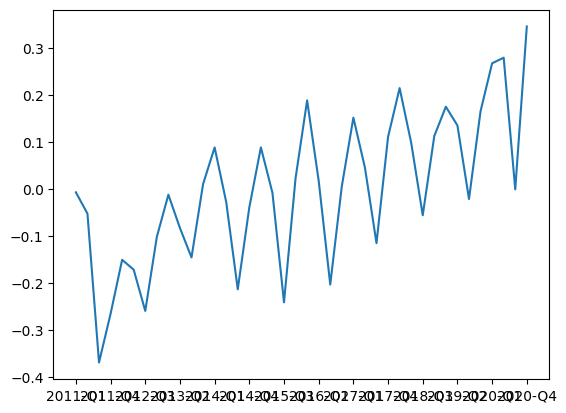


Lithuania



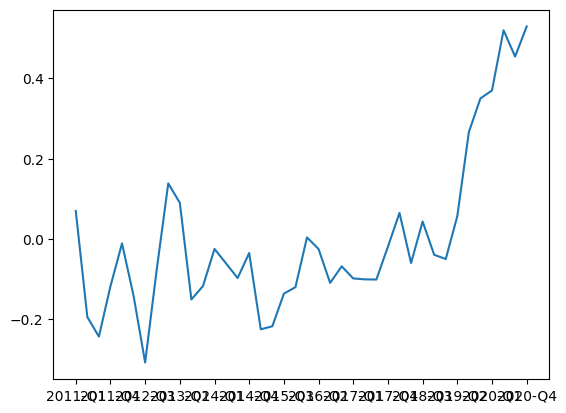


Poland



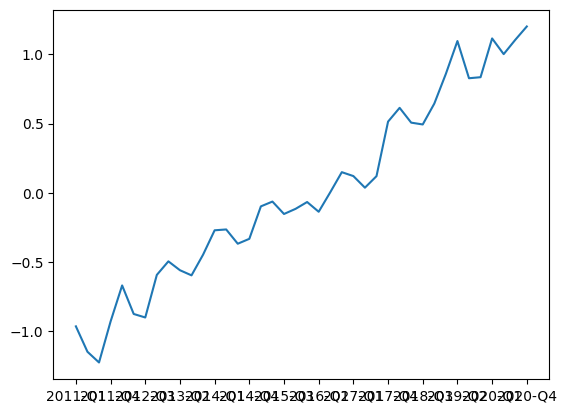


Finland



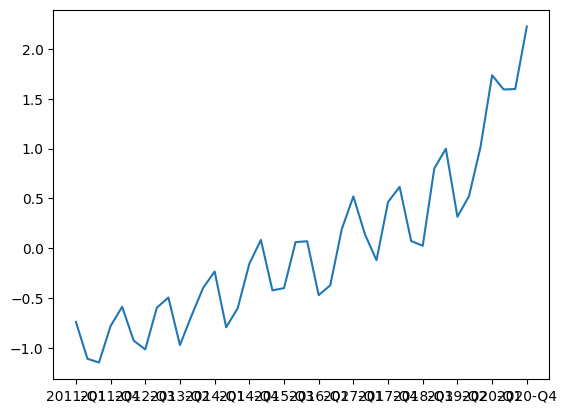


Sweden



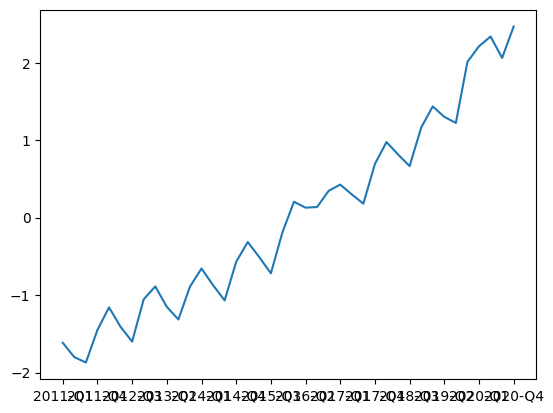

In [66]:


agg_country = {}
for country in country_names:
    # The next step is to calculate the `classic` task content intensity, i.e.
    # how important is a particular general task content category in the workforce
    # Here, we're looking at non-routine cognitive analytical tasks, as defined
    # by David Autor and Darron Acemoglu:
    combined[f"{country}_NRCA"] = combined[f"std_{country}_{task_items[0]}"] + combined[f"std_{country}_{task_items[1]}"] + combined[f"std_{country}_{task_items[2]}"]

    # And we standardise NRCA in a similar way.
    temp_mean = np.average(combined[f"{country}_NRCA"], weights=combined[f"share_{country}"])
    temp_sd = np.sqrt(np.average((combined[f"{country}_NRCA"] - temp_mean)**2, weights=combined[f"share_{country}"]))
    combined[f"std_{country}_NRCA"] = (combined[f"{country}_NRCA"] - temp_mean) / temp_sd
    
    # Finally, to track the changes over time, we have to calculate a country-level mean
    # Step 1: multiply the value by the share of such workers.
    combined[f"multip_{country}_NRCA"] = combined[f"std_{country}_NRCA"] * combined[f"share_{country}"]
    
    # Step 2: sum it up (it basically becomes another weighted mean)
    agg_country[f"agg_{country}"] = combined.groupby(["TIME"])[f"multip_{country}_NRCA"].sum().reset_index()
    
    # We can plot it now!
    print("\n" + country + "\n")
    plt.plot(agg_country[f"agg_{country}"]["TIME"], agg_country[f"agg_{country}"][f"multip_{country}_NRCA"])
    plt.xticks(range(0, len(agg_country[f"agg_{country}"]), 3), agg_country[f"agg_{country}"]["TIME"][::3])
    plt.show()
    

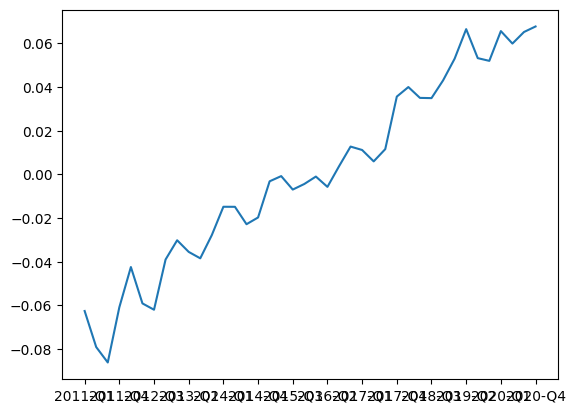

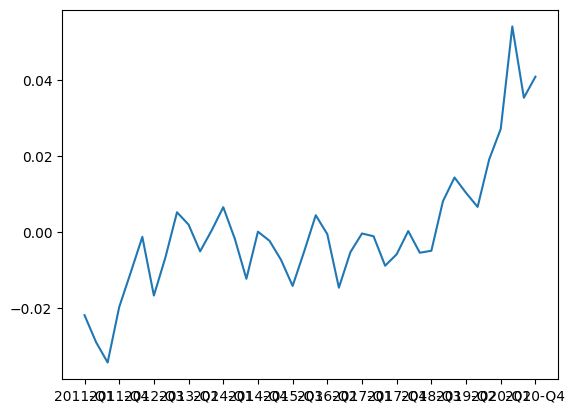

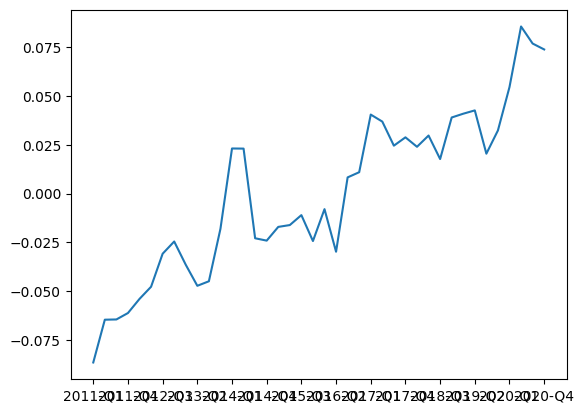

In [34]:
# The next step is to calculate the `classic` task content intensity, i.e.
# how important is a particular general task content category in the workforce
# Here, we're looking at non-routine cognitive analytical tasks, as defined
# by David Autor and Darron Acemoglu:



combined["Belgium_NRCA"] = combined["std_Belgium_t_4A2a4"] + combined["std_Belgium_t_4A2b2"] + combined["std_Belgium_t_4A4a1"]
combined["Poland_NRCA"] = combined["std_Poland_t_4A2a4"] + combined["std_Poland_t_4A2b2"] + combined["std_Poland_t_4A4a1"]
combined["Spain_NRCA"] = combined["std_Spain_t_4A2a4"] + combined["std_Spain_t_4A2b2"] + combined["std_Spain_t_4A4a1"]

# And we standardise NRCA in a similar way.
temp_mean = np.average(combined["Belgium_NRCA"], weights=combined["share_Belgium"])
temp_sd = np.sqrt(np.average((combined["Belgium_NRCA"] - temp_mean)**2, weights=combined["share_Belgium"]))
combined["std_Belgium_NRCA"] = (combined["Belgium_NRCA"] - temp_mean) / temp_sd

temp_mean = np.average(combined["Poland_NRCA"], weights=combined["share_Poland"])
temp_sd = np.sqrt(np.average((combined["Poland_NRCA"] - temp_mean)**2, weights=combined["share_Poland"]))
combined["std_Poland_NRCA"] = (combined["Poland_NRCA"] - temp_mean) / temp_sd

temp_mean = np.average(combined["Spain_NRCA"], weights=combined["share_Spain"])
temp_sd = np.sqrt(np.average((combined["Spain_NRCA"] - temp_mean)**2, weights=combined["share_Spain"]))
combined["std_Spain_NRCA"] = (combined["Spain_NRCA"] - temp_mean) / temp_sd


# Finally, to track the changes over time, we have to calculate a country-level mean
# Step 1: multiply the value by the share of such workers.
combined["multip_Spain_NRCA"] = combined["std_Spain_NRCA"] * combined["share_Spain"]
combined["multip_Belgium_NRCA"] = combined["std_Belgium_NRCA"] * combined["share_Belgium"]
combined["multip_Poland_NRCA"] = combined["std_Poland_NRCA"] * combined["share_Poland"]

# Step 2: sum it up (it basically becomes another weighted mean)

agg_Spain = combined.groupby(["TIME"])["multip_Spain_NRCA"].sum().reset_index()
agg_Belgium = combined.groupby(["TIME"])["multip_Belgium_NRCA"].sum().reset_index()
agg_Poland = combined.groupby(["TIME"])["multip_Poland_NRCA"].sum().reset_index()

# We can plot it now!


plt.plot(agg_Poland["TIME"], agg_Poland["multip_Poland_NRCA"])
plt.xticks(range(0, len(agg_Poland), 3), agg_Poland["TIME"][::3])
plt.show()

plt.plot(agg_Spain["TIME"], agg_Spain["multip_Spain_NRCA"])
plt.xticks(range(0, len(agg_Spain), 3), agg_Spain["TIME"][::3])
plt.show()

plt.plot(agg_Belgium["TIME"], agg_Belgium["multip_Belgium_NRCA"])
plt.xticks(range(0, len(agg_Belgium), 3), agg_Belgium["TIME"][::3])
plt.show()

# If this code gets automated and cleaned properly,
#  you should be able to easily add other countries as well as other tasks.
# E.g.:

# Routine manual
# 4.A.3.a.3	Controlling Machines and Processes
# 4.C.2.d.1.i	Spend Time Making Repetitive Motions
# 4.C.3.d.3	Pace Determined by Speed of Equipment
